# Base Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
import tensorflow_hub as hub
import re
import spacy
import matplotlib.pyplot as plt

nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\joaco\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joaco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history, metrics = ['accuracy', 'F1']):
  plt.figure(figsize=(14, 10))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.history[metric], color=colors[0], label='train')
    plt.plot(history.history['val_'+metric],
             color=colors[0], linestyle="--", label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

# Load Data

In [3]:
TRAIN_SIZE = 0.85
PATH = 'data/'

#"Odio", "Mujeres", "Comunidad LGBTQ+", "Comunidades Migrantes", "Pueblos Originarios"
classes = ["Odio", "Mujeres", "Comunidad LGBTQ+", "Comunidades Migrantes", "Pueblos Originarios"]
data_train = pd.read_csv(PATH+'tweets_train.csv')

train_data = data_train.sample(frac=1).reset_index(drop=True)
train_data, val_data = train_data.iloc[:int(TRAIN_SIZE*len(train_data)), :], train_data.iloc[int(TRAIN_SIZE*len(train_data)):, :]

print(train_data.shape)
print(val_data.shape)

(1917, 10)
(339, 10)


# Preprocess Data

## Nivel considerado odio

In [4]:
NIVEL_PARA_ODIO = 2

if NIVEL_PARA_ODIO == 3:
    # Considerar que un dato pertenece solo si las 3 personas pusieron que pertenece
    train_data['Odio'] = np.where(train_data['Odio'] == 3, 1, 0)
    val_data['Odio'] = np.where(val_data['Odio'] == 3, 1, 0)
    train_data['Mujeres'] = np.where(train_data['Mujeres'] == 3, 1, 0)
    val_data['Mujeres'] = np.where(val_data['Mujeres'] == 3, 1, 0)
    train_data['Comunidad LGBTQ+'] = np.where(train_data['Comunidad LGBTQ+'] == 3, 1, 0)
    val_data['Comunidad LGBTQ+'] = np.where(val_data['Comunidad LGBTQ+'] == 3, 1, 0)
    train_data['Comunidades Migrantes'] = np.where(train_data['Comunidades Migrantes'] == 3, 1, 0)
    val_data['Comunidades Migrantes'] = np.where(val_data['Comunidades Migrantes'] == 3, 1, 0)
    train_data['Pueblos Originarios'] = np.where(train_data['Pueblos Originarios'] == 3, 1, 0)
    val_data['Pueblos Originarios'] = np.where(val_data['Pueblos Originarios'] == 3, 1, 0)   
elif NIVEL_PARA_ODIO == 2:
    train_data['Odio'] = np.where((train_data['Odio'] == 3) | (train_data['Odio'] == 2), 1, 0)
    val_data['Odio'] = np.where((val_data['Odio'] == 3) | (val_data['Odio'] == 2), 1, 0)
    train_data['Mujeres'] = np.where((train_data['Mujeres'] == 3) | (train_data['Mujeres'] == 2), 1, 0)
    val_data['Mujeres'] = np.where((val_data['Mujeres'] == 3) | (val_data['Mujeres'] == 2), 1, 0)
    train_data['Comunidad LGBTQ+'] = np.where((train_data['Comunidad LGBTQ+'] == 3) | (train_data['Comunidad LGBTQ+'] == 2), 1, 0)
    val_data['Comunidad LGBTQ+'] = np.where((val_data['Comunidad LGBTQ+'] == 3) | (val_data['Comunidad LGBTQ+'] == 2), 1, 0)
    train_data['Comunidades Migrantes'] = np.where((train_data['Comunidades Migrantes'] == 3) | (train_data['Comunidades Migrantes'] == 2), 1, 0)
    val_data['Comunidades Migrantes'] = np.where((val_data['Comunidades Migrantes'] == 3) | (val_data['Comunidades Migrantes'] == 2), 1, 0)
    train_data['Pueblos Originarios'] = np.where((train_data['Pueblos Originarios'] == 3) | (train_data['Pueblos Originarios'] == 2), 1, 0)
    val_data['Pueblos Originarios'] = np.where((val_data['Pueblos Originarios'] == 3) | (val_data['Pueblos Originarios'] == 2), 1, 0)

## Cleaning

In [5]:
import unidecode
import spacy_spanish_lemmatizer

stemmer = SnowballStemmer("spanish")
nlp = spacy.load("es_core_news_lg")
#nlp.replace_pipe("lemmatizer", "spanish_lemmatizer")
stop_words = stopwords.words("spanish")

def clean_text(text, len_words):
    TEXT_CLEANING_RE = "@\S+" # separado porque solo agarraba la primera etiqueta
    TEXT_CLEANING_RE2 = "https?:\S+|http?:\S|[^A-Za-z0-9]+"
    TEXT_CLEANING_RE_EXTRA = "[^\w\s]"
    if len_words == 1:
        text = re.sub(r'\b\w{1}\b', '', str(text).lower()).strip()
    elif len_words == 2:
        text = re.sub(r'\b\w{1,2}\b', '', str(text).lower()).strip()
    elif len_words == 3:
        text = re.sub(r'\b\w{1,3}\b', '', str(text).lower()).strip()
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    text = re.sub(TEXT_CLEANING_RE2, ' ', str(text).lower()).strip()
    text = re.sub(TEXT_CLEANING_RE_EXTRA, ' ', str(text).lower()).strip()
    return text

def preprocess(text,cleaning=True, stopwords=True, stemming=False, lemmatizer=False, len_words=1):
    text = unidecode.unidecode(text)
    if cleaning:
        text = clean_text(text, len_words)
    tokens = []
    for token in text.split():
        if (not stopwords) or (stopwords and (token not in stop_words)):
            if stemming:
                tokens.append(stemmer.stem(token))
            elif lemmatizer:
                doc = nlp(token)
                tokens.append(unidecode.unidecode(doc[0].lemma_))
            else:
                tokens.append(token)    
    text2 = " ".join(tokens)
    if cleaning:
        text2 = clean_text(text2, len_words)
    return text2

c:\Users\joaco\anaconda3\envs\conda_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Pruebas de preprocesado

In [6]:
import random

tweet = train_data['text'][random.randint(0, len(train_data))]
#tweet = "@jalessandri @RicardoVenegas7 @hola Estos wueones extranjero haitianos,peruanos, venezolanos y los más ladrones .cubanos .vinieron a echar el país,,,toda está gente vende en las calles y puras cochinadas como vendiendo almuerzo pobladas en la catedral fuera de este país por eso boto RECHAZO....."

print(tweet,"\n")  
print("Sin stopwords:",preprocess(tweet, stopwords=False))
print("Con stemming:",preprocess(tweet, cleaning=True, stopwords=False, stemming=True))
print("Con lematizacion:",preprocess(tweet, cleaning=True, stopwords=False, stemming=False, lemmatizer=True, len_words=1))

@cbarreda01 Full violación a los Derechos del Consumidor... 

Sin stopwords: full violacion los derechos del consumidor
Con stemming: full violacion los derech del consumidor
Con lematizacion: full violacion el derecho del consumidor


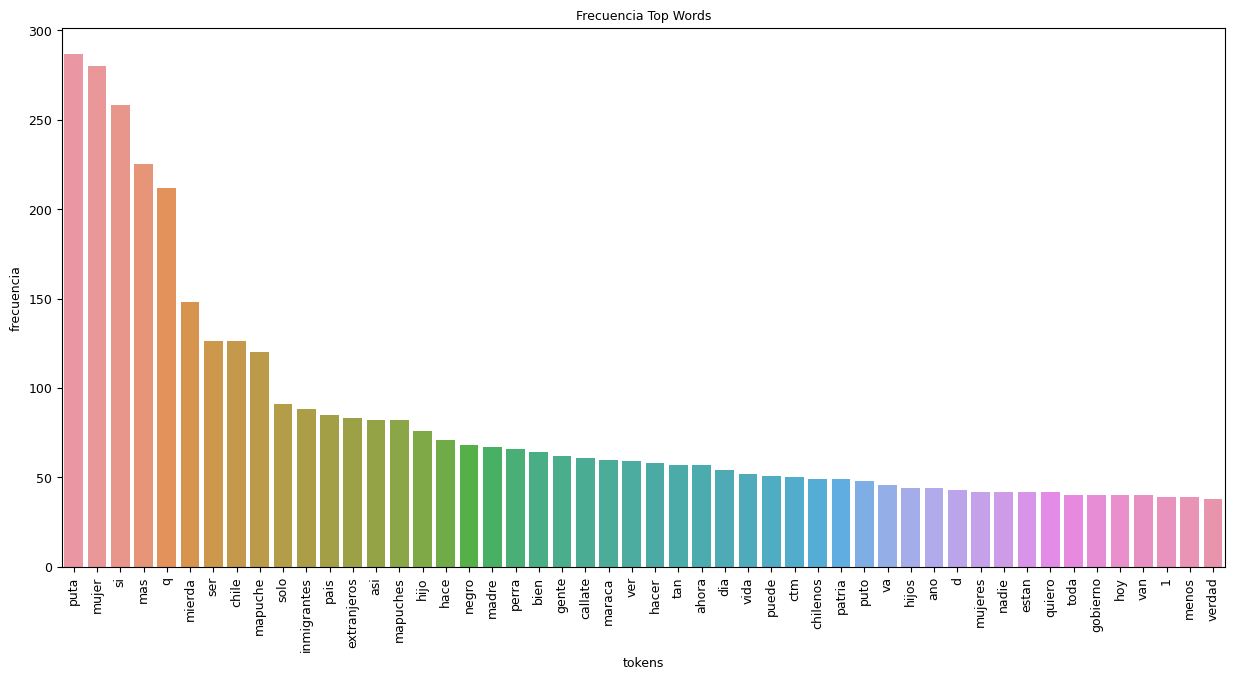

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

n_top_words = 50

tweets= [preprocess(tweet, cleaning=True, stopwords=True, stemming=False, lemmatizer=False, len_words=0).split() for tweet in train_data['text'].values]

top_words = Counter([item for sublist in [tweet for tweet in tweets] for item in sublist]).most_common(n_top_words)

fig, ax = plt.subplots(figsize=(15,7),nrows=1)
ax.set_title('Frecuencia Top Words',fontsize=9)
sns.barplot(x=[w[0] for w in top_words], y=[w[1] for w in top_words])
ax.set_xlabel("tokens",fontsize=9)
ax.set_ylabel("frecuencia",fontsize=9)
ax.tick_params(axis='both', which='major', labelsize=9)
plt.xticks(rotation=90)
plt.show()

# Definición de modelo y datos a usar

In [8]:
CLEANING = True
STOPWORDS = True
STEMMING = True
LEMMATIZER = False
LEN_WORDS = 2

train_tweets = [preprocess(tweet, cleaning=CLEANING, stopwords=STOPWORDS, stemming=STEMMING, lemmatizer=LEMMATIZER, len_words=LEN_WORDS) for tweet in train_data['text'].values]
val_tweets = [preprocess(tweet) for tweet in val_data['text'].values]
y_train_categorias = train_data[classes].values
y_val_categorias = val_data[classes].values

print(y_train_categorias.shape)
print(y_val_categorias.shape)

(1917, 5)
(339, 5)


In [9]:
import tensorflow_addons as tfa
METRICS = [
      tf.metrics.BinaryAccuracy(name='accuracy'),
      tfa.metrics.F1Score(name='F1',average='macro', num_classes=len(classes)),
      tf.metrics.Recall(name='recall')
]

c:\Users\joaco\anaconda3\envs\conda_gpu\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [10]:
from transformers import WordpieceTokenizer, BasicTokenizer, BertTokenizer
bert_path = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1'
bert_layer = hub.KerasLayer(bert_path, trainable=True)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
bert_tokenizer = BertTokenizer(vocab_file, do_lower_case)

In [11]:
def prepare_input_for_bert(texts, bert_tokenizer, max_seq_len):
  x, y, z =[],[], []
  for text in texts:
    tokens = bert_tokenizer.tokenize(text)
    tokens = tokens[:min(len(tokens),max_seq_len-2)]
    tokens = ["[CLS]"]+tokens+["[SEP]"]
    token_ids = bert_tokenizer.convert_tokens_to_ids(tokens)
    input_ids = token_ids + [0] * (max_seq_len-len(token_ids))
    input_mask = ([1] * len(token_ids)) + ([0] *  (max_seq_len - len(token_ids)))
    input_type = ([0] * (len(token_ids)-1)) + [1] + ([0] *  (max_seq_len - len(token_ids)))
    x.append(np.array(input_ids))
    y.append(np.array(input_mask))
    z.append(np.array(input_type))
  return [tf.cast(np.array(x),tf.int32), tf.cast(np.array(y),tf.int32), tf.cast(np.array(z),tf.int32)]

In [12]:
def bert_based_model(max_seq_len):
  input_ids = keras.layers.Input(shape=(max_seq_len,), dtype='int32', name="input_ids")
  input_mask = keras.layers.Input(shape=(max_seq_len,), dtype='int32', name="input_masks")
  input_segments = keras.layers.Input(shape=(max_seq_len,), dtype='int32', name="input_segments")
  pooled_output, sequence_output = bert_layer([input_ids, input_mask, input_segments])
  cls_out = keras.layers.GlobalAveragePooling1D()(sequence_output)
  logits = keras.layers.Dropout(0.7)(cls_out)
  logits = keras.layers.Dense(768)(logits)
  logits = keras.layers.Dense(500)(logits)
  logits = keras.layers.Dropout(0.7)(logits)
  logits = keras.layers.Dense(len(classes), activation="sigmoid")(logits)
  classifier = keras.Model([input_ids, input_mask, input_segments],logits)

  return classifier

In [13]:
max_seq_len=50
bert_input_train = prepare_input_for_bert(train_tweets,bert_tokenizer,max_seq_len)
bert_input_val = prepare_input_for_bert(val_tweets,bert_tokenizer,max_seq_len)
print(bert_input_train[0].shape)

(1917, 50)


In [14]:
bert_model = bert_based_model(max_seq_len)
bert_model.summary()
bert_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics = METRICS)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 50)]         0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 50)]         0           []                               
                                                                                                  
 input_segments (InputLayer)    [(None, 50)]         0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_ids[0][0]',              
                                 (None, 50, 768)]                 'input_masks[0][0]',        

# Entrenamiento

In [17]:
if len(classes) == 1:
    metrica_monitoreada = 'val_accuracy'
else:
    metrica_monitoreada = 'val_F1'

print("metrica monitoreada", metrica_monitoreada)

checkpoint_path = 'BERT_based_checkpoints/BERT_based.{epoch:02d}-{val_F1:.4f}.h5'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,save_best_only=True,monitor=metrica_monitoreada,mode='max')
es = tf.keras.callbacks.EarlyStopping(monitor=metrica_monitoreada, patience=5, restore_best_weights=True, mode='max')
history_bert_model = bert_model.fit(bert_input_train, y_train_categorias, epochs=80, batch_size=8, validation_data=(bert_input_val, y_val_categorias), callbacks=[es])

metrica monitoreada val_F1
Epoch 1/80
240/240 [==============================] - 35s 145ms/step - loss: 0.0198 - accuracy: 0.9924 - F1: 0.5361 - recall: 0.9804 - val_loss: 0.8390 - val_accuracy: 0.8602 - val_F1: 0.4743 - val_recall: 0.5360
Epoch 2/80
240/240 [==============================] - 32s 135ms/step - loss: 0.0227 - accuracy: 0.9925 - F1: 0.5130 - recall: 0.9804 - val_loss: 0.8095 - val_accuracy: 0.8708 - val_F1: 0.4863 - val_recall: 0.6081
Epoch 3/80
240/240 [==============================] - 32s 134ms/step - loss: 0.0229 - accuracy: 0.9931 - F1: 0.5352 - recall: 0.9810 - val_loss: 0.8462 - val_accuracy: 0.8631 - val_F1: 0.4705 - val_recall: 0.6715
Epoch 4/80
240/240 [==============================] - 32s 135ms/step - loss: 0.0193 - accuracy: 0.9935 - F1: 0.5237 - recall: 0.9841 - val_loss: 0.8426 - val_accuracy: 0.8631 - val_F1: 0.5132 - val_recall: 0.5706
Epoch 5/80
240/240 [==============================] - 33s 136ms/step - loss: 0.0125 - accuracy: 0.9952 - F1: 0.5438 - rec

In [19]:
bert_model.save('BERT_model/BERT_'+str(len(classes))+'class_F1-{:.4f}.h5'.format((history_bert_model.history['val_F1'][-1])))

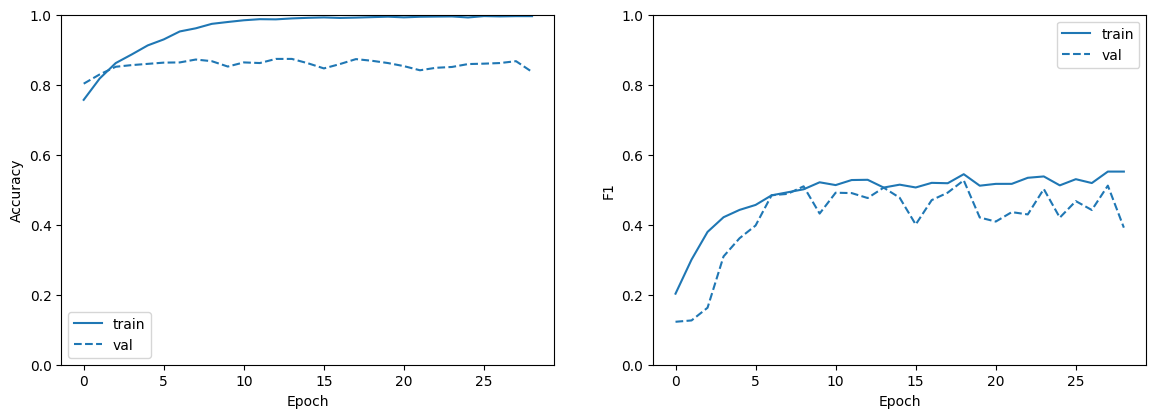

In [16]:
plot_metrics(history_bert_model)

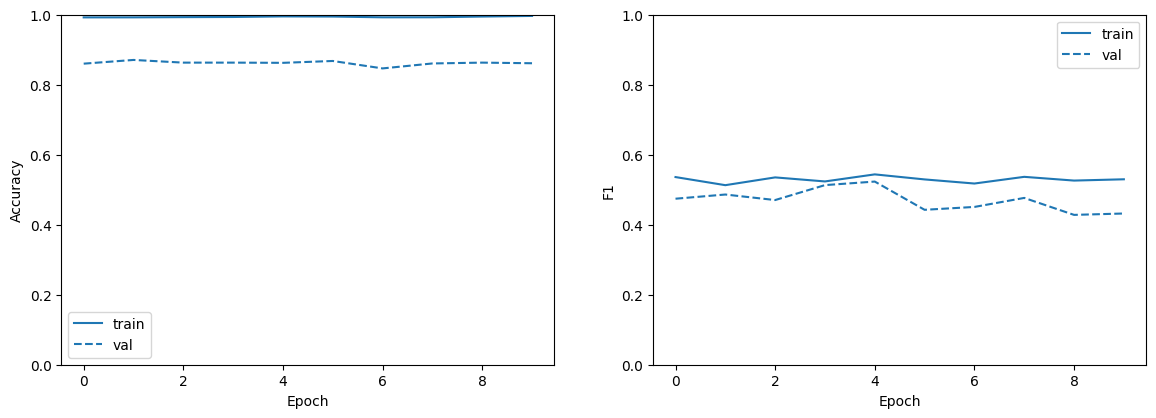

In [18]:
plot_metrics(history_bert_model)

# Predicciones

In [77]:
test_data = pd.read_csv('data/public_test.csv')
test_tweets = [preprocess(tweet) for tweet in test_data['text'].values]
bert_input_test = prepare_input_for_bert(test_tweets,bert_tokenizer,max_seq_len)

y_pred_categorias = bert_model.predict(bert_input_test)
for row in y_pred_categorias:
    for i in range(len(classes)):
        if row[i] > 0.5:
            row[i] = 1
        else:
            row[i] = 0
y_pred_categorias = pd.DataFrame(y_pred_categorias, columns=[classes])
y_pred_categorias.to_csv('predicciones.csv', index=False)
y_pred_categorias

72/72 [==============================] - 4s 45ms/step


,Odio,Mujeres,Comunidad LGBTQ+,Comunidades Migrantes,Pueblos Originarios
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2286,1.0,0.0,0.0,1.0,0.0
2287,0.0,0.0,0.0,0.0,0.0
2288,0.0,0.0,0.0,0.0,0.0
2289,1.0,0.0,1.0,0.0,0.0


In [78]:
#!shutdown -s -t 60